<a href="https://colab.research.google.com/github/brownnyi/E-commerce_data-analyst/blob/main/E_commerce_%EB%8D%B0%EC%9D%B4%ED%84%B0_%EB%B6%84%EC%84%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from google.oauth2 import service_account
from google.cloud import bigquery

import warnings
warnings.filterwarnings('ignore')

In [4]:
SERVICE_ACCOUNT_FILE = "bigquery-test-434505-a5eb5eebc9c9.json"  # 키 json 파일
credentials = service_account.Credentials.from_service_account_file(SERVICE_ACCOUNT_FILE)
project_id = "bigquery-test-434505" # 각자 프로젝트에 맞게 수정
client = bigquery.Client(credentials=credentials, project=project_id)

def import_bigquery_data(query):
    query_job = client.query(query)
    return query_job.to_dataframe()

# 사용 데이터 및 목적

- 사용 데이터 : order_items, orders, products, users

- 목적 : 커머스 데이터에 필수적으로 확인해야할 데이터와 이에 맞는 비즈니스 통찰력 획득, 매출을 높이기 위한 인사이트 획득

In [5]:
products = import_bigquery_data('''
    SELECT *
    FROM `bigquery-public-data.thelook_ecommerce.products`
    ;
''')
order_items = import_bigquery_data('''
    SELECT *
    FROM `bigquery-public-data.thelook_ecommerce.order_items`
    WHERE created_at BETWEEN '2024-01-01' AND '2024-09-01'
    ;
''')
orders = import_bigquery_data('''
    SELECT *
    FROM `bigquery-public-data.thelook_ecommerce.orders`
    WHERE created_at BETWEEN '2024-01-01' AND '2024-09-01'
    ;
''')
users = import_bigquery_data('''
    SELECT *
    FROM `bigquery-public-data.thelook_ecommerce.users`
    ;
''')
events = import_bigquery_data('''
    SELECT *
    FROM `bigquery-public-data.thelook_ecommerce.events`
    WHERE created_at BETWEEN '2024-01-01' AND '2024-09-01'
    ;
''')

## 1. 매출

- 월별 매출액, 구매수, 구매자수, 평균 구매 금액 및 주문수

In [6]:
# 전처리

using_order_items = order_items[~order_items['status'].isin(['Cancelled','Returned'])]
using_order_items['month'] = [str(i)[5:7] for i in using_order_items['created_at']]
using_order_items = using_order_items[['order_id','sale_price','month']]

using_orders = orders[['order_id', 'user_id', 'num_of_item']]

# data merge

using_merge_data = pd.merge(
    using_order_items,
    using_orders,
    how = 'inner',
    on = 'order_id'
)

using_merge_data['revenue'] = round(using_merge_data['num_of_item'] * using_merge_data['sale_price'])

In [7]:
result1 = pd.merge(
    using_merge_data.groupby('month')[['order_id','user_id']].nunique().reset_index(),
    using_merge_data.groupby('month')[['revenue']].sum().reset_index(),
    on = 'month'
)

result1.columns = ['month','order_cnt','usr_cnt','revenue']

In [8]:
#평균 주문 금액
result1['aov'] = round(result1['revenue'] / result1['order_cnt'])

#평균 주문수
result1['평균주문수'] = round(result1['order_cnt'] / result1['usr_cnt'],2)

In [9]:
result1

,month,order_cnt,usr_cnt,revenue,aov,평균주문수
0,01,2915,2865,443006.0,152.0,1.02
1,02,2963,2905,476629.0,161.0,1.02
2,03,3413,3322,559873.0,164.0,1.03
3,04,3713,3623,604348.0,163.0,1.02
4,05,3943,3809,640491.0,162.0,1.04
5,06,4448,4270,719091.0,162.0,1.04
6,07,5379,5084,899565.0,167.0,1.06
7,08,7493,6644,1145060.0,153.0,1.13


## 2. 주요 고객은 누구인가?

- 출신, 성별, 연령대 분포

In [10]:
# 출신, 성별 유저수 분포
revenue_usr_data = pd.merge(users, using_merge_data, how = 'right', left_on = 'id', right_on = 'user_id')

In [11]:
revenue_usr_data.groupby(['country','gender'])[['id']].nunique().sort_values(by = 'id', ascending = False)

id
country        gender      
China          M       4658
               F       4646
United States  M       3161
               F       3123
Brasil         F       1981
               M       1962
South Korea    F        714
               M        709
France         M        689
               F        675
United Kingdom F        647
               M        626
Germany        F        599
               M        594
Spain          F        574
               M        542
Japan          M        331
Australia      F        304
               M        293
Japan          F        290
Belgium        M        199
               F        188
Poland         F         33
               M         32
Colombia       F          4
España         M          1
Colombia       M          1
Austria        F          1

In [12]:
# 성별 매출 분포

revenue_usr_data.groupby('gender')[['revenue']].sum()
#남녀별로 차이가 별로 안남

,revenue
gender,
F,2559196.0
M,2928867.0


In [13]:
age_category_lst = []
for i in revenue_usr_data['age']:
    if i < 10:
        age_category_lst.append(0)
    elif i < 20:
        age_category_lst.append(10)
    elif i < 30:
        age_category_lst.append(20)
    elif i < 40:
        age_category_lst.append(30)
    elif i < 50:
        age_category_lst.append(40)
    else:
        age_category_lst.append(50)

revenue_usr_data['age_category'] = age_category_lst

In [14]:
revenue_usr_data.groupby('age_category')[['revenue']].sum().sort_values(by = 'revenue', ascending = False)

,revenue
age_category,
50,1906140.0
40,963191.0
20,951249.0
30,913944.0
10,753539.0


In [15]:
revenue_usr_data.groupby('age_category')[['order_id']].nunique().sort_values(by = 'order_id', ascending = False)

#50대의 구매율이 높음

,order_id
age_category,
50,12036
40,5741
20,5730
30,5628
10,4571


## 3. 브랜드와 상품 카테고리의 분포

In [16]:
brand_category_data = import_bigquery_data('''
    SELECT C.brand as brand, ROUND(SUM(A.sale_price * B.num_of_item), 2) as revenue,
    SUM(B.num_of_item) as quantity
    FROM `bigquery-public-data.thelook_ecommerce.order_items` as A
    INNER JOIN `bigquery-public-data.thelook_ecommerce.orders` as B
    ON A.order_id = B.order_id
    INNER JOIN `bigquery-public-data.thelook_ecommerce.products` as C
    ON A.product_id = C.id
    GROUP BY C.brand
    ORDER BY revenue DESC
    ;
''')

In [17]:
brand_category_data.head(10)

,brand,revenue,quantity
0,Calvin Klein,388549.61,6146
1,Diesel,369708.38,2764
2,Carhartt,352773.92,4914
3,True Religion,334413.69,1654
4,7 For All Mankind,319760.00,2030
5,Tommy Hilfiger,238647.37,3187
6,Volcom,207332.92,3509
7,The North Face,201378.22,445
8,Columbia,197174.81,2805
9,Joe's Jeans,196987.48,1290


In [18]:
goods_category_data = import_bigquery_data('''
    SELECT C.category as category, ROUND(SUM(A.sale_price * B.num_of_item), 2) as revenue,
    SUM(B.num_of_item) as quantity
    FROM `bigquery-public-data.thelook_ecommerce.order_items` as A
    INNER JOIN `bigquery-public-data.thelook_ecommerce.orders` as B
    ON A.order_id = B.order_id
    INNER JOIN `bigquery-public-data.thelook_ecommerce.products` as C
    ON A.product_id = C.id
    GROUP BY C.category
    ORDER BY revenue DESC
    ;
''')

In [19]:
goods_category_data

,category,revenue,quantity
0,Outerwear & Coats,2528038.12,17263
1,Jeans,2363768.65,24258
2,Sweaters,1577019.53,20763
3,Swim,1241421.62,21609
4,Fashion Hoodies & Sweatshirts,1214293.17,22534
5,Suits & Sport Coats,1210469.07,9601
6,Sleep & Lounge,1044938.80,21378
7,Shorts,971437.01,21097
8,Tops & Tees,946422.57,22877
9,Active,857522.65,17340


## 4. 취소 및 반품

In [20]:
cancel_return_data = pd.merge(
    order_items[order_items['status'].isin(['Returned','Cancelled'])],
    users,
    left_on = 'user_id',
    right_on = 'id',
    how = 'left'
)

In [21]:
cancel_return_data.groupby('country')[['order_id']].nunique().sort_values(by = 'order_id', ascending = False)

,order_id
country,
China,3813
United States,2594
Brasil,1715
South Korea,593
United Kingdom,570
France,514
Spain,464
Germany,447
Japan,270


## 5. 마케팅 채널별

In [22]:
import_bigquery_data('''
    SELECT B.traffic_source as traffic_source, COUNT(DISTINCT A.user_id) as total_customer
    FROM `bigquery-public-data.thelook_ecommerce.order_items` as A
    INNER JOIN `bigquery-public-data.thelook_ecommerce.users` as B
    ON A.user_id = B.id
    WHERE A.status NOT IN ('Cancelled', 'Returned')
    GROUP BY B.traffic_source
    ORDER BY total_customer DESC
    ;
''')

,traffic_source,total_customer
0,Search,46148
1,Organic,9824
2,Facebook,4063
3,Email,3389
4,Display,2701


# 파레토 차트

## 파레토 법칙
- 80:20 법칙이라고도 불리는데, 80%의 결과가 20%의 원인에 의해 발생한다는 법칙

##파레토 차트
- 파레토 차트는 막대와 선 그래프 모두 포함된 차트 유형으로, 개별 값은 막대로 내림차순으로 표시되고 누적합계는 선으로 표시

    - 축 설명
        - 왼쪽축은 발생 빈도, 비용이나 중요한 측정 단위를 나타낼 수도 있음
        - 오른쪽축은 총 빈도, 비용 또는 측정 단위의 총계에 대한 누적 백분율

    - 목적 : 요인 집합 중에서 가장 중요한 것을 강조하는 것

    - 이점
        - 우선순위 선택
        - 관리 가능한 부분으로 분류
        - 생산성 증가

In [23]:
using_merge_data = pd.merge(
    order_items[~order_items['status'].isin(['Cancelled','Returned'])],
    orders,
    how = 'inner',
    on = 'order_id'
)
using_merge_data['revenue'] = round(using_merge_data['num_of_item'] * using_merge_data['sale_price'])
order_data = using_merge_data[['order_id', 'product_id', 'revenue']]

In [24]:
len(set(products['category']))

26

In [25]:
using_data = pd.merge(
    order_data,
    products,
    how = 'left',
    left_on = 'product_id',
    right_on = 'id'
)[['order_id','category']]

In [26]:
count_data = using_data['category'].value_counts()

In [27]:
# x축 설정
x = count_data.index

# y축 설정
y = count_data.values

#비율 설정
ratio = (y/y.sum()).cumsum()

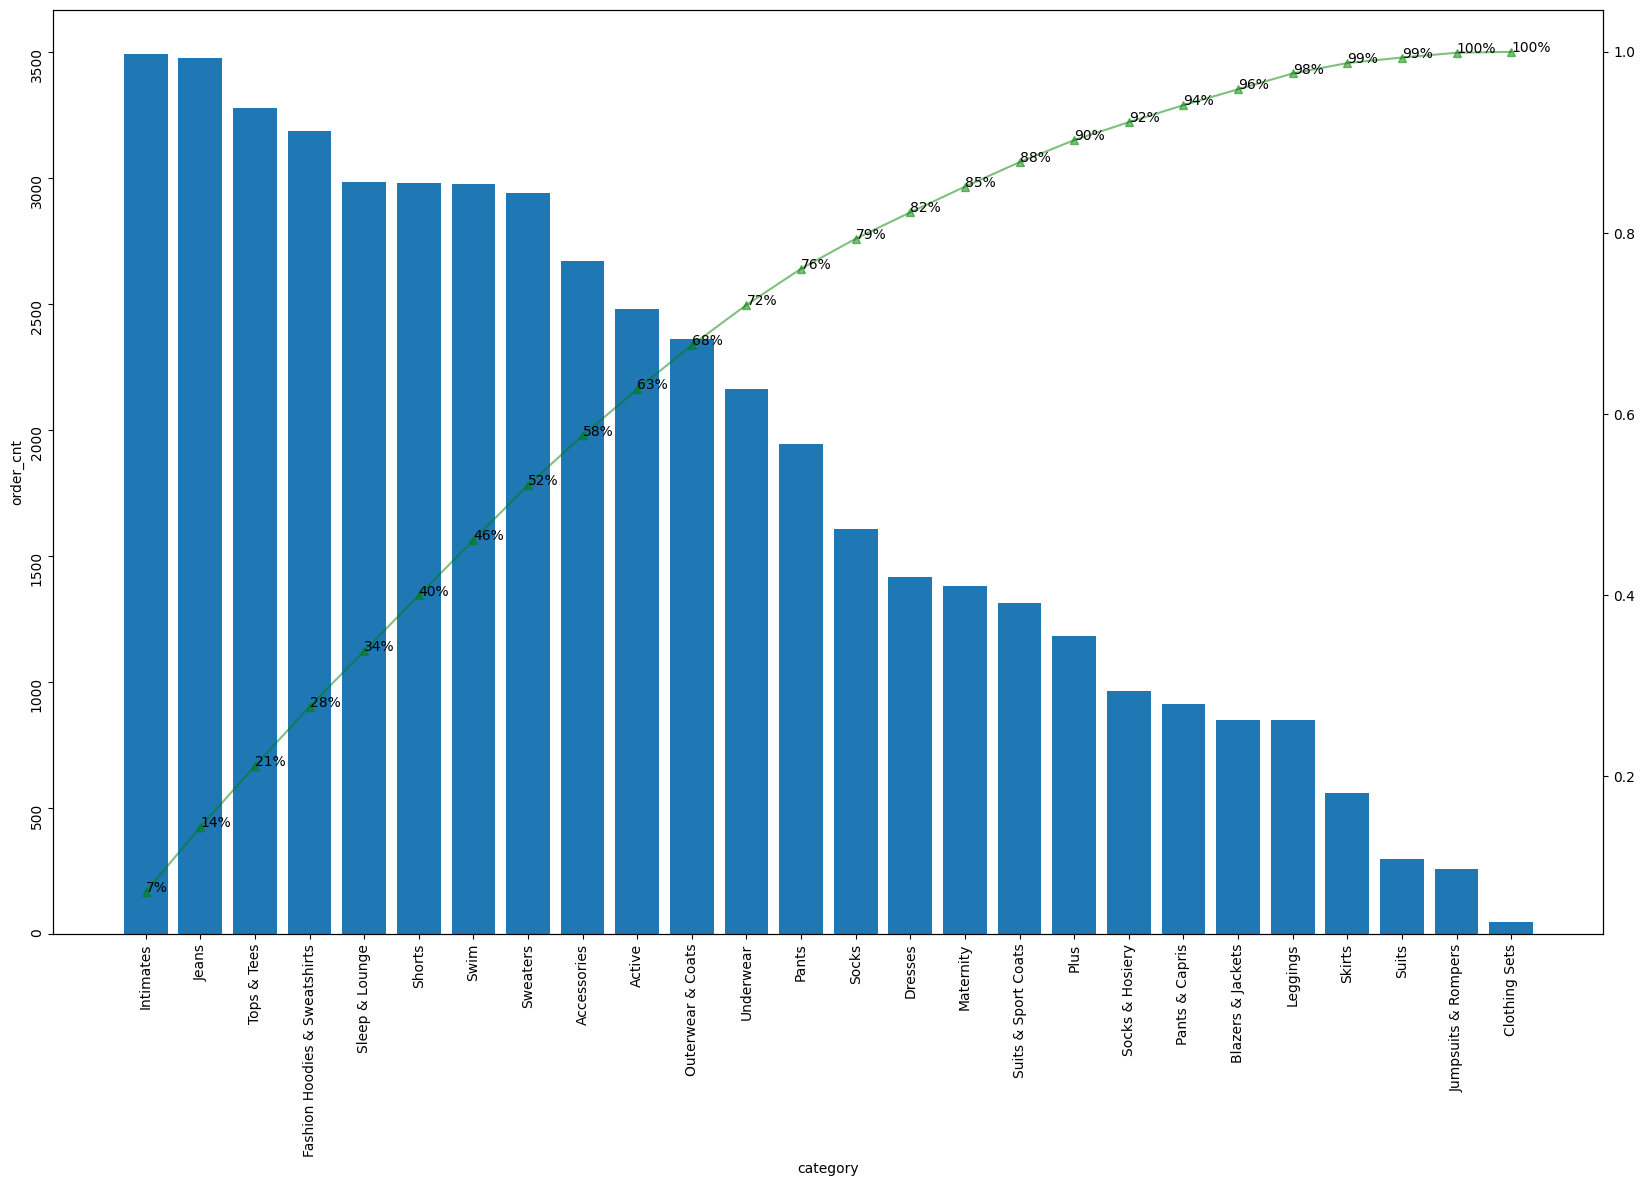

In [28]:
# 그래프 생성
fig, ax = plt.subplots(figsize = (20, 12))

# 바차트 생성
ax.bar(x, y)

# 라인차트 생성
line_chart = ax.twinx()
line_chart.plot(x, ratio, '-g^', alpha = 0.5)

#%값 입력
ratio_sum_percent = ['{0:.0%}'.format(x) for x in ratio]

for idx, i in enumerate(ratio_sum_percent):
    line_chart.annotate(i, ([x[idx]], ratio[idx]))

# 라벨 지정
ax.set_xlabel('category')
ax.set_ylabel('order_cnt')

# 축 회전
ax.tick_params(rotation = 90)

plt.show()

# Funnel Chart

## AARRR

- Acquisition, Activation, Retention, Revenue, Referral

- 이는 고객 여정을 개선하여 비즈니스를 성장시키는 데 사용할 수 있는 일련의 지표를 나타냄

- 유저의 라이프 사이클을 통해 유저들을 판단함

- 관리하기 위한 대표적인 지표 예시

1. Acqusition(획득)
- 이러한 기준은 서비스에 따라 신규 방문, 앱 설치, 서비스 결제 등으로 설정 가능

- 신규 유저 획득을 위한 적절한 채널을 확보하는게 중요

2. Activation(활동, 활성화)
- 획득과 마찬가지로 서비스에 따라 상이

- 장바구니 담기, 상세 페이지 조회, 회원 가입으로 볼 수 있음

3. Retention(유지)
- 고객 유지가 잘 되고 있느냐를 확인하는 단계

- 재구매율, 재방문율등 서비스에 따라 상이

4. Revenue(매출)

5. Refferal(추천)

- 마지막 단계인 만큼 퍼널에서 가장 아래에 위치

- 추천으로 이뤄지기 어려운 만큼 다양한 방법에 대해 고민이 필요한 단계

## 아래 예시에서 사용할 지표
1. Acqusition(획득) : 유저 유입

2. Activation(활동, 활성화) : 회원가입

3. Retention(유지) : 재방문

4. Revenue(매출) : 구매

5. Referral(추천) : 추천

참고사항 : 예시는 한달 데이터만 활용 (2024년 7월)

In [29]:
events

,id,user_id,sequence_number,session_id,created_at,ip_address,city,state,postal_code,browser,traffic_source,uri,event_type
0,1914158,<NA>,3,019385f6-844d-461d-b292-31e622b5bf2d,2024-03-05 08:44:00+00:00,150.170.166.100,Oshu-shi,Iwate,023-0003,Firefox,Adwords,/cancel,cancel
1,1342994,<NA>,3,b3664397-d69e-41e9-9d5c-51aae52f7ce2,2024-03-21 13:39:00+00:00,213.234.17.116,São Paulo,São Paulo,02675-031,Chrome,Adwords,/cancel,cancel
2,1328951,<NA>,3,852c39cb-00c5-4dd9-9175-aaf239e48c39,2024-07-03 11:59:00+00:00,72.21.78.119,São Paulo,São Paulo,02675-031,Chrome,Adwords,/cancel,cancel
3,1827385,<NA>,3,25d1e750-5e70-46ff-9064-7f25a145744f,2024-06-23 13:17:00+00:00,136.38.134.76,São Paulo,São Paulo,02675-031,Chrome,Adwords,/cancel,cancel
4,1614552,<NA>,3,d976accb-4561-4427-8a9c-e0faa11a8238,2024-03-29 07:27:00+00:00,207.160.53.233,São Paulo,São Paulo,04941-175,Firefox,Email,/cancel,cancel
...,...,...,...,...,...,...,...,...,...,...,...,...,...
607301,882822,68160,5,487ba57a-4d2d-4531-8190-ce8713c2de22,2024-06-20 21:34:20+00:00,6.101.131.87,Norton Canes,England,WS11,Chrome,Adwords,/purchase,purchase
607302,1225958,94434,5,161ba11d-c9c7-4d63-9464-d9b42cf68d6a,2024-08-06 06:52:00+00:00,152.168.30.7,Walsall,England,WS3,Chrome,Facebook,/purchase,purchase
607303,75864,5833,5,fd603980-8c03-47e7-812c-3827529a55f2,2024-04-28 06:45:38+00:00,172.122.127.80,Burntwood,England,WS7,Firefox,Adwords,/purchase,purchase
607304,581025,44866,5,b8cede01-2378-4ade-81c2-8f97873accaa,2024-08-30 23:21:56.820681+00:00,159.41.109.126,Wolverhampton,England,WV10,Firefox,Email,/purchase,purchase


In [30]:
# 2024년 7월 가입 유저

july_usrs_lst = users[
    (users['created_at'] >= '2024-07-01') &
    (users['created_at'] < '2024-08-01')
]['id'].tolist()


In [31]:
events['user_id'] = events['user_id'].fillna(-1)

using_events = events[
    (events['created_at'] >= '2024-07-01') &
    (events['created_at'] < '2024-08-01') &
    (
        (events['user_id'] == -1) | (events['user_id'].isin(july_usrs_lst))
    )
]

In [32]:
using_events

,id,user_id,sequence_number,session_id,created_at,ip_address,city,state,postal_code,browser,traffic_source,uri,event_type
2,1328951,-1,3,852c39cb-00c5-4dd9-9175-aaf239e48c39,2024-07-03 11:59:00+00:00,72.21.78.119,São Paulo,São Paulo,02675-031,Chrome,Adwords,/cancel,cancel
16,2336082,-1,3,d2b9596d-9c65-45da-830f-10be926aca98,2024-07-27 06:19:00+00:00,47.13.215.15,Taizhou,Beijing,100084,Chrome,Adwords,/cancel,cancel
20,2388461,-1,3,87c88e8b-f56f-48b9-88a3-435f146a9567,2024-07-13 02:08:00+00:00,89.158.49.76,Xingtai,Beijing,100091,Chrome,Email,/cancel,cancel
28,1985329,-1,3,da344427-93b7-4ac5-9d81-b055603b69c5,2024-07-29 03:45:00+00:00,143.252.46.13,Suzhou,Beijing,102676,Chrome,YouTube,/cancel,cancel
29,1316624,-1,3,6378fa23-0914-44ce-9f3c-f6bf5e388e4d,2024-07-24 17:41:00+00:00,176.78.147.38,New York,New York,10304,Firefox,Adwords,/cancel,cancel
...,...,...,...,...,...,...,...,...,...,...,...,...,...
607049,587730,45371,5,cd57168c-978d-46b8-89a4-60d1acf68be0,2024-07-28 05:05:54+00:00,171.165.67.49,Port Orchard,Washington,98367,Chrome,Email,/purchase,purchase
607128,147441,11253,7,e0eab8cd-0705-44e1-8842-4c57b66cac7e,2024-07-18 04:09:45+00:00,75.69.99.73,Bishop Auckland,England,DL14,Chrome,Organic,/purchase,purchase
607246,268272,20666,13,9fd17a15-a699-456a-ac88-29f4e7d092cc,2024-07-18 07:28:01+00:00,124.248.11.96,Dagenham,England,RM8,Chrome,Email,/purchase,purchase
607251,100000,7708,5,02bf4e40-bf66-4d94-9822-7a199d84db0f,2024-07-18 08:29:28+00:00,92.171.229.97,Bon-y-maen,Wales,SA1,Chrome,Email,/purchase,purchase


In [33]:
user_id_lst = list(set(using_events[using_events['user_id']!=-1]['user_id'].astype(int)))

# 이후 값 통일을 위해 정수형 변형후 문자형으로
user_id_lst = [str(int(i)) for i in user_id_lst]

In [34]:
user_session_lst = set(using_events[using_events['user_id'].isin(user_id_lst)]['session_id'])

In [35]:
# 비회원인 경우에는 유저의 session_id을 뺀 값을 활용

not_user_session_lst = set(using_events[using_events['user_id'] == -1]['session_id'])

not_usr_lst = list(not_user_session_lst - user_session_lst)

In [36]:
not_usr_lst

['7af049c2-4c4d-4b77-9d5a-5c7e00ab1289',
 '0c9e95c8-de73-45a9-9051-004e5fbfa3d3',
 '3c1bfc82-c3db-4572-8cf1-378fd54e385b',
 'eff58882-20f1-4578-adba-820a05c6c7b5',
 '4c62dc6b-7e00-41ba-9166-68911dd301ec',
 'e147ef19-dfac-4f91-b7e8-45459f008ab4',
 '72e54641-1fbf-4a60-b5ab-db5fee4dc96d',
 'ec38b420-9736-44b7-a3cd-090086587df1',
 '0f47a23a-86af-449c-bca7-a6b33d25e246',
 '32879f15-bb56-48ec-9812-200fb018fe23',
 '5dda4a2f-b5a6-4ab9-add0-c3bc0162a2b3',
 '85d5896c-755e-42c7-a5c0-f03b8a5ddb2d',
 '609dc9d9-3eb5-431f-b96c-f86614de07b6',
 'ebc175c7-d5c8-412f-a917-bd1a2e4752ce',
 '1080b99d-91cb-431b-a2ec-860d7c4c0817',
 '6772c436-4149-4ba2-989a-7c814d53f138',
 '90b05819-bed3-4209-abf2-f2add004384d',
 '1855d52e-bcf4-416d-b36d-20b3ff818680',
 'bfae789f-0bcd-47ad-b943-c8d1f346a375',
 '3d80cc80-69c3-4bfb-ae5f-a95a40621822',
 '3f01407f-0b10-4ca3-ba86-acf20e325d19',
 'b06342cf-83ff-41df-8e2a-1e377b8be0b0',
 '9546950c-e628-46ec-8525-2826b2c27970',
 '49fa76c5-cb44-482c-8632-7b9f02f89b3f',
 'ae5ccc04-17a7-

acquisition

In [37]:
acquisition = pd.DataFrame([user_id_lst + not_usr_lst], index = ['user_id']).T

In [38]:
acquisition['type'] = 1

In [39]:
acquisition.head()

,user_id,type
0,22530,1
1,4103,1
2,67592,1
3,40972,1
4,65549,1


activation

In [40]:
activation = pd.DataFrame(user_id_lst, columns = ['user_id'])

activation['type'] = 2

In [41]:
activation

,user_id,type
0,22530,2
1,4103,2
2,67592,2
3,40972,2
4,65549,2
...,...,...
468,77780,2
469,10207,2
470,2023,2
471,12270,2


In [42]:
set(using_events['event_type'])

{'cancel', 'cart', 'department', 'home', 'product', 'purchase'}

Retention

In [43]:
value_counts = using_events[
    (using_events['event_type'].isin(['home', 'cart'])) &
    (using_events['user_id'] != -1)
]['user_id'].value_counts()

revisit_usr_lst = list(value_counts[value_counts >= 2].index)

#이후 값 통일을 위해 정수형 변형후 문자형으
revisit_usr_lst = [str(int(i)) for i in revisit_usr_lst]

In [44]:
revisit_usr_lst

['97991',
 '45246',
 '30557',
 '49064',
 '91086',
 '6926',
 '64867',
 '96570',
 '73541',
 '47797',
 '9115',
 '77866',
 '65549',
 '13614',
 '15607',
 '92658',
 '38726',
 '60184',
 '45127',
 '50705',
 '17764',
 '20666',
 '13828',
 '63350',
 '37496',
 '73649',
 '5587',
 '34712',
 '25916',
 '66600',
 '78509',
 '67505',
 '72702',
 '53126',
 '88741',
 '73375',
 '94154',
 '71435',
 '90861',
 '88520',
 '54295',
 '22196',
 '53932',
 '38499',
 '55736',
 '13933',
 '46059',
 '80542',
 '53422',
 '20695',
 '97900',
 '92360',
 '53992',
 '36090',
 '23578',
 '1465',
 '27296',
 '64002',
 '25128',
 '22827',
 '26144',
 '33948',
 '12095',
 '71624',
 '89468',
 '86040',
 '91971',
 '11253',
 '82340',
 '1287',
 '48627',
 '29240',
 '95131',
 '84227',
 '72937',
 '70989',
 '76092',
 '22564',
 '7644',
 '72288',
 '36272',
 '59215',
 '37239',
 '28628',
 '84322',
 '18165',
 '7614',
 '64779',
 '16083',
 '22530',
 '66667',
 '56190',
 '72180',
 '74668',
 '53688',
 '77780',
 '19783',
 '47129',
 '21130',
 '56089',
 '5095'

In [45]:
retention = pd.DataFrame(revisit_usr_lst, columns = ['user_id'])
retention['type'] = 3

Revenue

In [46]:
order_usr_lst = list(set(using_events[using_events['event_type'] == 'purchase']['user_id']))

In [47]:
order_usr_lst = [str(int(i)) for i in order_usr_lst]

In [48]:
revenue = pd.DataFrame(order_usr_lst, columns = ['user_id'])
revenue['type'] = 4

In [49]:
revenue.head()

,user_id,type
0,22530,4
1,4103,4
2,67592,4
3,40972,4
4,65549,4


퍼널 데이터 생성

In [50]:
aarrr_data = pd.concat([acquisition, activation, retention, revenue])

In [51]:
aarrr_data

,user_id,type
0,22530,1
1,4103,1
2,67592,1
3,40972,1
4,65549,1
...,...,...
461,77780,4
462,10207,4
463,2023,4
464,12270,4


In [52]:
aarrr_data['type'].value_counts()

,count
type,
1,8119
2,473
3,473
4,466


In [53]:
import numpy as np

In [54]:
phase_list = [1,2,3,4]
result_list = []

intersectArray = np.array(aarrr_data.loc[(aarrr_data['type'] == phase_list[0]), 'user_id'])
initialCnt = len(intersectArray) #모수

phase_name = phase_list[0] #시작 패

for phase in phase_list:
    #단계별 유저수
    phaseArray = np.array(aarrr_data.loc[(aarrr_data['type'] == phase), 'user_id'])
    #퍼널 통과 유저 array
    intersectArray = set(intersectArray) & set(phaseArray)
    intersectCnt = (len(intersectArray)) #퍼널 통과 유저수

    #데이터 입력
    result_list.append([phase, intersectCnt, intersectCnt/initialCnt])

In [55]:
# 최종 퍼널 데이터
funnel_data = pd.DataFrame(result_list, columns = ['퍼널단계','유저수','전환율'])

In [56]:
funnel_data

,퍼널단계,유저수,전환율
0,1,8119,1.000000
1,2,473,0.058258
2,3,473,0.058258
3,4,466,0.057396


In [57]:
funnel_data.style.format(
    {'전환율' : '{:,.1%}'.format}
).set_properties(
    **{'text-align' : 'left'}
).bar(
    subset = ['전환율'], width = 100, align = 'left', vmin = 0, vmax = 1
).set_table_styles(
    [
        {'selector' : '', 'props' : [('border','1px solid grey')]},
        {'selector' : 'tbody td', 'props' : [('border','1px solid grey')]},
        {'selector' : 'th', 'props' : [('border', '1px solid grey')]}
    ]
)

,퍼널단계,유저수,전환율
0,1,8119,100.0%
1,2,473,5.8%
2,3,473,5.8%
3,4,466,5.7%


## 리텐션
- 리텐션은 특정 날짜에 애플리케이션을 다시 방문(혹은 구매 등 특정 지표)한 사용자의 비율
    - 즉, 재방문율, 잔존율과 동의어
    - 여기서 특정 날짜 이전에 사용자와 이 애플리케이션 간의 잠재적인 상호작용을 고려하지 않음

- 이러한 방법은 가장 널리 퍼져 있으며 응용 프로그램의 전반적인 유지 능력에 대한 좋은 아이디어를 제공

- 리텐션은 다음과 같이 표현 가능

$리텐션 비율 = (지속적으로 활동중인 사용자 수 / 초기 코호트의 총 사용자 수) * 100 $

## 코호트 분석에서 리텐션 활용
- 코호트 분석은 장기적인 사용자 유지 패턴을 이해하고, 비즈니스와 제품 개선에 중요한 통찰을 제공하는데 유용한 도구

### - 사용자 행동 분석
- 코호트 분석을 통해 시간이 지남에 따라 사용자 행동을 추적

- 예를 들어, 특정 기능이나 캠페인 도입 후 리텐션이 어떻게 변화하는지를 분석하여 어떤 변화가 사용자 유지에 긍정적 또는 부정적 영향을 미치는지 파악 가능

### - 제품 개선
- 리텐션 데이터를 분석함으로써 제품이나 서비스의 문제점을 발견하고 개선 가능

- 특정 시점에서 리텐션이 하락할 경우, 해당 시점에 변화를 분석하여 조치를 취할 수 있음

### - 마케팅 전략 평가
- 캠페인 후 리텐션 비율이 높아지면, 캠페인이 긍정적인 영향을 미쳤다는 것을 의미

### - 비즈니스 결정 지원
- 리텐션 데이터를 기반으로 비즈니스 전략을 조정

### - 고객 세분화
- 리텐션 분석을 통해 사용자의 행동 패턴을 이해하고, 다양한 세그먼트(세부 그룹)로 나누어 맞춤형 서비스를 제공할 수 있다.

In [58]:
import seaborn as sns

In [59]:
using_usr_lst = users[users['created_at'] > '2024-01-01']['id'].tolist()

using_order_data = orders[
    (~orders['status'].isin(['Cancelled','Returned'])) &
    (orders['user_id'].isin(using_usr_lst))
]

In [63]:
using_order_data['order_dt'] = [str(i)[:7] for i in using_order_data['created_at']]

In [64]:
using_order_data

,order_id,user_id,status,gender,created_at,returned_at,shipped_at,delivered_at,num_of_item,order_dt
3398,55,46,Complete,F,2024-05-14 13:08:00+00:00,NaT,2024-05-17 10:36:00+00:00,2024-05-19 08:31:00+00:00,2,2024-05
3399,58,46,Complete,F,2024-07-02 13:08:00+00:00,NaT,2024-07-03 13:23:00+00:00,2024-07-03 23:54:00+00:00,1,2024-07
3400,60,47,Complete,F,2024-07-22 11:18:00+00:00,NaT,2024-07-23 11:31:00+00:00,2024-07-24 06:41:00+00:00,1,2024-07
3402,66,53,Complete,F,2024-03-22 11:13:00+00:00,NaT,2024-03-25 09:44:00+00:00,2024-03-28 14:50:00+00:00,1,2024-03
3403,67,53,Complete,F,2024-03-15 11:13:00+00:00,NaT,2024-03-17 17:20:00+00:00,2024-03-20 10:57:00+00:00,1,2024-03
...,...,...,...,...,...,...,...,...,...,...
45336,124270,99724,Shipped,M,2024-07-21 09:07:00+00:00,NaT,2024-07-23 22:39:00+00:00,NaT,1,2024-07
45349,124470,99879,Shipped,M,2024-08-19 12:03:00+00:00,NaT,2024-08-19 15:59:00+00:00,NaT,1,2024-08
45351,124485,99890,Shipped,M,2024-07-29 02:24:00+00:00,NaT,2024-07-29 20:37:00+00:00,NaT,1,2024-07
45354,124505,99904,Shipped,M,2024-06-16 14:51:00+00:00,NaT,2024-06-16 14:57:00+00:00,NaT,1,2024-06


In [65]:
using_order_data = using_order_data[['user_id', 'order_dt']]

In [66]:
using_order_data.head()

,user_id,order_dt
3398,46,2024-05
3399,46,2024-07
3400,47,2024-07
3402,53,2024-03
3403,53,2024-03


In [70]:
first_order_data = using_order_data.groupby('user_id')['order_dt'].min().reset_index()
first_order_data.columns = ['user_id', 'first_order_dt']

In [71]:
# 첫 주문월 계산
first_order_data.head()

,user_id,first_order_dt
0,7,2024-07
1,10,2024-07
2,18,2024-08
3,46,2024-05
4,47,2024-07


In [74]:
merge_data = pd.merge(
    using_order_data,
    first_order_data,
    how = 'left',
    on = 'user_id'
).drop_duplicates()

In [75]:
merge_data.head()

,user_id,order_dt,first_order_dt
0,46,2024-05,2024-05
1,46,2024-07,2024-05
2,47,2024-07,2024-07
3,53,2024-03,2024-03
5,77,2024-06,2024-06


In [77]:
# 각각의 유저 구하기
cohorts = merge_data.groupby(['order_dt','first_order_dt'])[['user_id']].count().reset_index()


In [79]:
cohorts.columns = ['order_dt', 'first_order_dt', 'user_cnt']

In [80]:
cohorts = cohorts.sort_values(by = ['first_order_dt', 'order_dt'])

In [81]:
cohorts

,order_dt,first_order_dt,user_cnt
0,2024-01,2024-01,87
1,2024-02,2024-01,8
3,2024-03,2024-01,8
6,2024-04,2024-01,5
10,2024-05,2024-01,11
15,2024-06,2024-01,6
21,2024-07,2024-01,13
28,2024-08,2024-01,10
2,2024-02,2024-02,244
4,2024-03,2024-02,14


In [82]:
# 기간별로 레이블 붙이기
each_period = cohorts['first_order_dt'].value_counts().sort_index()

In [83]:
cohortperiod = []

for x in each_period:
    for y in range(x):
        cohortperiod.append(y)

In [ ]:
cohortperiod

In [85]:
cohorts['order_dt'] = cohortperiod
cohorts = cohorts.set_index(['first_order_dt','order_dt'])

In [ ]:
cohorts

In [87]:
cohorts = cohorts['user_cnt'].unstack(1)

In [88]:
cohorts

order_dt,0,1,2,3,4,5,6,7
first_order_dt,,,,,,,,
2024-01,87,8,8,5,11,6,13,10
2024-02,244,14,22,20,25,22,27,<NA>
2024-03,461,56,52,46,50,55,<NA>,<NA>
2024-04,672,78,87,67,81,<NA>,<NA>,<NA>
2024-05,891,105,115,116,<NA>,<NA>,<NA>,<NA>
2024-06,1154,204,203,<NA>,<NA>,<NA>,<NA>,<NA>
2024-07,1591,311,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2024-08,3037,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


In [102]:
#비율로 표현하기

user_retention = cohorts.divide(cohorts[0], axis = 0)

user_retention = user_retention.replace('<NA>', np.nan)

In [104]:
user_retention

order_dt,0,1,2,3,4,5,6,7
first_order_dt,,,,,,,,
2024-01,1.0,0.091954,0.091954,0.057471,0.126437,0.068966,0.149425,0.114943
2024-02,1.0,0.057377,0.090164,0.081967,0.102459,0.090164,0.110656,<NA>
2024-03,1.0,0.121475,0.112798,0.099783,0.10846,0.119306,<NA>,<NA>
2024-04,1.0,0.116071,0.129464,0.099702,0.120536,<NA>,<NA>,<NA>
2024-05,1.0,0.117845,0.129068,0.130191,<NA>,<NA>,<NA>,<NA>
2024-06,1.0,0.176776,0.17591,<NA>,<NA>,<NA>,<NA>,<NA>
2024-07,1.0,0.195475,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2024-08,1.0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


user_retention.astype(float): 데이터프레임을 float 타입으로 변환하여 NaN을 처리. 이 과정에서 <NA> 값이 NaN으로 변환

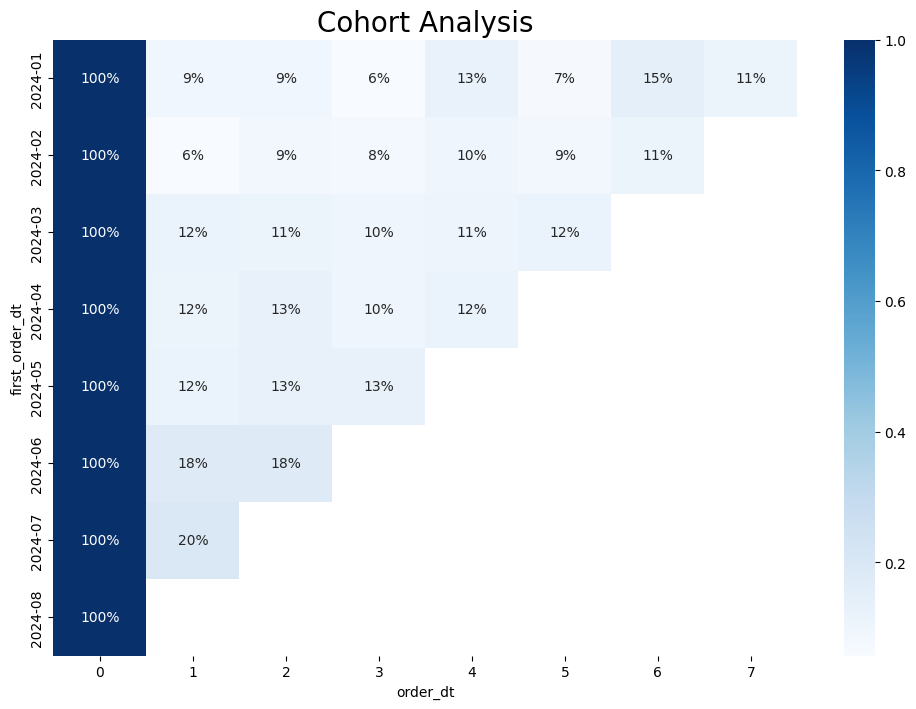

In [108]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 예제 데이터프레임: user_retention에서 NA 값을 NaN으로 변환
user_retention_nan = user_retention.astype(float)

# 코호트 분석 히트맵 그리기
plt.figure(figsize=(12, 8))
plt.title('Cohort Analysis', fontsize=20)

# 결측치를 마스크하여 빈 칸으로 표시
sns.heatmap(user_retention_nan, annot=True, fmt='.0%', cmap='Blues', mask=user_retention_nan.isna())

plt.show()